In [1]:
##%matplotlib widget
## with %matplotlib notebook: seems to require ipympl as part of environment, either
## part of the conda environment or "pip install ipympl"
## otherwise, does not show ANY plots in notebook, plt.savefig() works
%matplotlib notebook  
##%matplotlib inline    ## --plt.savefig()  works, but re-sizing does NOT


This notebook is a short demo to illustrate execution.   For odd historical reasons, it uses "toy Monte Carlo" (simulated data)for "training" and "full LHCB MC" for validation.

The network architecture is a "simple" model that uses 1 input channel (the KDE [kernel density estimator] but from the track parameters) feeding 5 convolutional layers followed by a fully connected layer.

In today's version, the network will start with weights from a previously trained version.
 

Check the current GPU usage. Please try to be nice!

In [2]:
!nvidia-smi

Thu Jun  4 21:06:27 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN V             Off  | 00000000:03:00.0 Off |                  N/A |
| 28%   31C    P8    23W / 250W |     12MiB / 12066MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla P100-PCIE...  Off  | 00000000:83:00.0 Off |                    0 |
| N/A   30C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

> **WARNING**: The card numbers here are *not* the same as in CUDA. You have been warned.

## Imports

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import pandas as pd

# Python 3 standard library
from pathlib import Path

from torchsummary import summary

### Set up local parameters

In [4]:
n_epochs = 200

# Name is the output file name


##  190810  mds
folder = '02June2020_CNN5Layer_Ca_another200epochs_K'
name = '02June2020_CNN5Layer_Ca_another200epochs_K'

# Make an output folder named "name" (change if you want)

## Special instructions for those working on goofy at UC
## Please be very careful to make sure that your folder
## does not live in a subdirectory of your home directory
## this disk has very little capacity. Instead, use 
## a subdirectory in /share/lazy with a symbolic link to
## it in this (the notebooks) subdirectory
folder = '/share/lazy/michael/ML/' + folder
output = Path(folder)


# Size of batches
batch_size = 128

# How fast to learn
learning_rate = 3e-4

Make the output directory if it does not exist:

In [5]:
output.mkdir(exist_ok=True)

## Get the helper functions

Add the directory with the model
definitions to the path so we can import from it:

> When you type `import X`,
Python searches `sys.path` for a python
file named `X.py` to import. So we need to add the model directory to the path.

In [6]:
# From model/collectdata.py
from model.collectdata_mdsA import collect_data

# From model/loss.py
##from loss import Loss
from model.alt_loss_A import Loss

# From model/training.py
from model.training import trainNet, select_gpu

# From model/models.py
##  will start with model from TwoFeatures_CNN6Layer_A in the first instance
##  see relevant cell below


from model.models_mds_01June20 import SimpleCNN5Layer_Ca as Model

from model.training import trainNet, select_gpu, Results
from model.plots import dual_train_plots, replace_in_ax

In [7]:
# This gets built up during the run - do not rerun this cell
results = pd.DataFrame([], columns=Results._fields)

Set up Torch device configuration. All tensors and model parameters need to know where to be put.
This takes a BUS ID number: The BUS ID is the same as the listing at the top of this script.

In [8]:
device = select_gpu(0)

1 available GPUs (initially using device 0):
  0 TITAN V


## Loading data

Load the dataset, split into parts, then move to device (see `collectdata.py` in the `../model` directory)

In [9]:
## newer vernacular
## Training dataset. You can put as many files here as desired.

## in this DEMO example we use only one 80K training set -- the model starts with well-trained weights,
## and using a smaller training set reduces both the time to load the data and the time to train an epoch
##  set the option load_XandXsq = True to use both DKE and KDE^2 as input features
train_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5',
                            '/share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5',
##                            'dataAA/Oct03_80K2_train.h5',
                             batch_size=batch_size,
## if we are using a larger dataset (240K events, with the datasets above, and 11 GB  of GPU memory),
## not the dataset will overflow the GPU memory; device=device will allow the data to move back
## and forth between the CPU and GPU memory. While this allows use of a larger dataset, it slows
## down performance by about 10%.  So comment out when not needed.
##                           device=device,
                            masking=True, shuffle=True,
                            load_XandXsq=False,
                            load_xy=False)

# Validation dataset. You can slice to reduce the size.
## dataAA -> /share/lazy/sokoloff/ML-data_AA/
val_loader = collect_data('/share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5',
## mds val_loader = collect_data('dataAA/HLT1CPU_1kevts_val.h5',

                          batch_size=batch_size,
                          slice=slice(256 * 39),
                          device=device,
                          masking=True, shuffle=False,
                          load_XandXsq=False,
                          load_xy=False)

Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Aug14_80K_train.h5 in 12.88 s
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_80K_train.h5 in 11.47 s
Constructing 160000 event dataset took 0.4973 s
Loading data...
Loaded /share/lazy/sokoloff/ML-data_AA/Oct03_20K_val.h5 in 2.847 s
Constructing 9984 event dataset took 3.439 s


# Preparing the model

Prepare a model, use multiple GPUs if they are VISIBLE, and move the model to the device.

In [10]:
model = Model()

##summary(model, input_size=(4, 4000))
##print(model.parameters)

## add the following code to allow the user to freeze the some of the weights corresponding 
## to those taken from an earlier model trained with the original target histograms
## presumably -- this leaves either the perturbative filter "fixed" and lets the 
## learning focus on the non-perturbative features, so get started faster, or vice versa
ct = 0
for child in model.children():
  print('ct, child = ',ct, "  ", child)
  if ct < 0:
    print("     About to set param.requires_grad=False for ct = ", ct, "params")
    for param in child.parameters():
        param.requires_grad = False 
  ct += 1
##  mds 200121 loss = Loss(epsilon=1e-5,coefficient=1.0)
loss = Loss(epsilon=1e-5,coefficient=2.5)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

ct, child =  0    Conv1d(1, 20, kernel_size=(25,), stride=(1,), padding=(12,))
ct, child =  1    Conv1d(20, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  2    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  3    Conv1d(10, 10, kernel_size=(15,), stride=(1,), padding=(7,))
ct, child =  4    Conv1d(10, 1, kernel_size=(5,), stride=(1,), padding=(2,))
ct, child =  5    Dropout(p=0.15, inplace=False)
ct, child =  6    Dropout(p=0.15, inplace=False)
ct, child =  7    Dropout(p=0.15, inplace=False)
ct, child =  8    Dropout(p=0.15, inplace=False)
ct, child =  9    Dropout(p=0.35, inplace=False)
ct, child =  10    Linear(in_features=4000, out_features=4000, bias=True)


In [11]:
print("Let's use", torch.cuda.device_count(), "GPUs!")
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)

Let's use 1 GPUs!


Let's move the model's weight matricies to the GPU:

In [12]:
print('output = ',output)
##print('oldOutput = ',oldOutput)
##  use the first four layers from a pre-existing model
##  see example at https://discuss.pytorch.org/t/how-to-load-part-of-pre-trained-model/1113

##   ML -> /share/lazy/sokoloff/ML
pretrained_dict = torch.load('/share/lazy/sokoloff/ML/02June2020_CNN5Layer_Ca_another40epochs_K/02June2020_CNN5Layer_Ca_another40epochs_K_final.pyt')
model_dict = model.state_dict()
## mds 190725 for debugging
print("for model_dict")
index = 0
for k,v in model_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
    
print(" \n","  for pretrained_dict")
index = 0
for k,v in pretrained_dict.items():
    print("index, k =  ",index,"  ",k)
    index = index+1
## mds  

print("model_dict instantiated")
# 1. filter out unnecessary keys
pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
## print("pretrained_dict iterated")
# 2. overwrite entries in the existing state dict
model_dict.update(pretrained_dict) 
##
#   when starting from a model with a fully connected last layer rather than a convolutional layer
# 3. load the new state dict
#   need to use strict=False as the two models state model attributes do not agree exactly
#   see https://pytorch.org/docs/master/_modules/torch/nn/modules/module.html#Module.load_state_dict

model.load_state_dict(pretrained_dict,strict=False)

## print('model_dict =    ', model_dict)


output =  /share/lazy/michael/ML/02June2020_CNN5Layer_Ca_another200epochs_K
for model_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
 
   for pretrained_dict
index, k =   0    conv1.weight
index, k =   1    conv1.bias
index, k =   2    conv2.weight
index, k =   3    conv2.bias
index, k =   4    conv3.weight
index, k =   5    conv3.bias
index, k =   6    conv4.weight
index, k =   7    conv4.bias
index, k =   8    conv5.weight
index, k =   9    conv5.bias
index, k =   10    fc1.weight
index, k =   11    fc1.bias
model_dict instantiated


<All keys matched successfully>

In [13]:
model = model.to(device)

## Train 



The body of this loop runs once per epoch. Results is a named tuple of values (loss per epoch for training and validation, time each). Start by setting up a plot first:

<IPython.core.display.Javascript object>


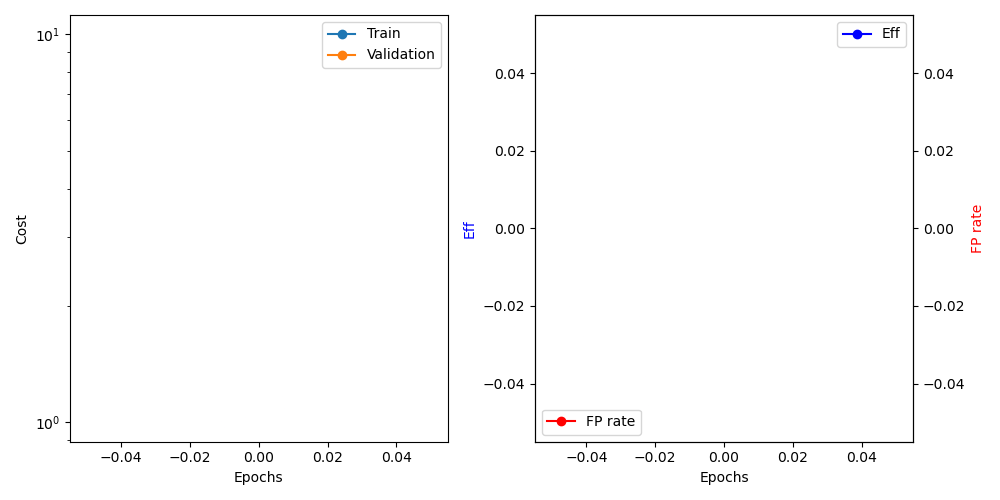

In [14]:
ax, tax, lax, lines = dual_train_plots()
fig = ax.figure
plt.tight_layout()

In [15]:
for result in trainNet(model, optimizer, loss,
                        train_loader, val_loader,
                        n_epochs, epoch_start=len(results),
                        notebook=True):
    
    results = results.append(pd.Series(result._asdict()), ignore_index=True)
    
    xs = results.index
    
    # Update the plot above
    lines['train'].set_data(results.index,results.cost)
    lines['val'].set_data(results.index,results.val)
    
    #filter first cost epoch (can be really large)
    max_cost = max(max(results.cost if len(results.cost)<2 else results.cost[1:]), max(results.val))
    min_cost = min(min(results.cost), min(results.val))
    
    # The plot limits need updating too
    
    
    
    ax.set_ylim(min_cost*.9, max_cost*1.1)  
    ax.set_xlim(-.5, len(results.cost) - .5)
    
    replace_in_ax(lax, lines['eff'], xs, results['eff_val'].apply(lambda x: x.eff_rate))
    replace_in_ax(tax, lines['fp'], xs, results['eff_val'].apply(lambda x: x.fp_rate))
    
    # Redraw the figure
    fig.canvas.draw()

    # Save each model state dictionary
    torch.save(model.state_dict(), output / f'{name}_{result.epoch}.pyt')

Number of batches: train = 1250, val = 78


Epoch 0: train=16.3388, val=15.1294, took 28.104 s
  Validation Found 41966 of 54504, added 1236 (eff 77.00%) (0.124 FP/event)


Epoch 1: train=16.3249, val=14.943, took 27.001 s
  Validation Found 41574 of 54504, added 956 (eff 76.28%) (0.0957 FP/event)


Epoch 2: train=16.2755, val=15.0244, took 25.985 s
  Validation Found 41862 of 54504, added 1088 (eff 76.81%) (0.109 FP/event)


Epoch 3: train=16.2216, val=14.8151, took 25.656 s
  Validation Found 41536 of 54504, added 935 (eff 76.21%) (0.0936 FP/event)


Epoch 4: train=16.1624, val=14.895, took 25.986 s
  Validation Found 42375 of 54504, added 1678 (eff 77.75%) (0.168 FP/event)


Epoch 5: train=16.103, val=14.7324, took 25.629 s
  Validation Found 41931 of 54504, added 1100 (eff 76.93%) (0.11 FP/event)


Epoch 6: train=16.0564, val=14.6692, took 24.995 s
  Validation Found 41852 of 54504, added 1092 (eff 76.79%) (0.109 FP/event)


Epoch 7: train=16.0043, val=14.6112, took 25.104 s
  Validation Found 41766 of 54504, added 1007 (eff 76.63%) (0.101 FP/event)


Epoch 8: train=15.9479, val=14.6489, took 25.355 s
  Validation Found 42036 of 54504, added 1045 (eff 77.12%) (0.105 FP/event)


Epoch 9: train=15.9113, val=14.5948, took 25.129 s
  Validation Found 42059 of 54504, added 1086 (eff 77.17%) (0.109 FP/event)


Epoch 10: train=15.8471, val=14.4803, took 25.551 s
  Validation Found 41782 of 54504, added 1014 (eff 76.66%) (0.102 FP/event)


Epoch 11: train=15.7972, val=14.4955, took 25.187 s
  Validation Found 42213 of 54504, added 1164 (eff 77.45%) (0.117 FP/event)


Epoch 12: train=15.7196, val=14.454, took 26.388 s
  Validation Found 42231 of 54504, added 1090 (eff 77.48%) (0.109 FP/event)


Epoch 13: train=15.6175, val=14.4299, took 25.169 s
  Validation Found 42586 of 54504, added 1130 (eff 78.13%) (0.113 FP/event)


Epoch 14: train=15.5439, val=14.3157, took 25.856 s
  Validation Found 42610 of 54504, added 1187 (eff 78.18%) (0.119 FP/event)


Epoch 15: train=15.435, val=14.1031, took 26.043 s
  Validation Found 42612 of 54504, added 1125 (eff 78.18%) (0.113 FP/event)


Epoch 16: train=15.3274, val=14.0857, took 25.306 s
  Validation Found 42576 of 54504, added 1052 (eff 78.12%) (0.105 FP/event)


Epoch 17: train=15.2353, val=13.9549, took 26.06 s
  Validation Found 42796 of 54504, added 1178 (eff 78.52%) (0.118 FP/event)


Epoch 18: train=15.1675, val=13.9495, took 25.275 s
  Validation Found 42919 of 54504, added 1182 (eff 78.74%) (0.118 FP/event)


Epoch 19: train=15.0971, val=13.8799, took 25.376 s
  Validation Found 42839 of 54504, added 1108 (eff 78.60%) (0.111 FP/event)


Epoch 20: train=15.029, val=13.7947, took 25.286 s
  Validation Found 42910 of 54504, added 1120 (eff 78.73%) (0.112 FP/event)


Epoch 21: train=14.9563, val=13.6788, took 25.333 s
  Validation Found 43021 of 54504, added 1136 (eff 78.93%) (0.114 FP/event)


Epoch 22: train=14.861, val=13.5747, took 25.18 s
  Validation Found 43092 of 54504, added 1118 (eff 79.06%) (0.112 FP/event)


Epoch 23: train=14.7885, val=13.5343, took 25.147 s
  Validation Found 43213 of 54504, added 1083 (eff 79.28%) (0.108 FP/event)


Epoch 24: train=14.7116, val=13.4353, took 25.08 s
  Validation Found 43392 of 54504, added 1193 (eff 79.61%) (0.119 FP/event)


Epoch 25: train=14.6638, val=13.3654, took 25.016 s
  Validation Found 43281 of 54504, added 1100 (eff 79.41%) (0.11 FP/event)


Epoch 26: train=14.6236, val=13.3694, took 25.395 s
  Validation Found 43680 of 54504, added 1377 (eff 80.14%) (0.138 FP/event)


Epoch 27: train=14.5771, val=13.4373, took 24.933 s
  Validation Found 43678 of 54504, added 1267 (eff 80.14%) (0.127 FP/event)


Epoch 28: train=14.5424, val=13.3077, took 25.397 s
  Validation Found 43621 of 54504, added 1223 (eff 80.03%) (0.122 FP/event)


Epoch 29: train=14.4921, val=13.3354, took 25.406 s
  Validation Found 43766 of 54504, added 1253 (eff 80.30%) (0.125 FP/event)


Epoch 30: train=14.4266, val=13.3703, took 25.002 s
  Validation Found 43906 of 54504, added 1348 (eff 80.56%) (0.135 FP/event)


Epoch 31: train=14.3787, val=13.1827, took 25.13 s
  Validation Found 43740 of 54504, added 1098 (eff 80.25%) (0.11 FP/event)


Epoch 32: train=14.3031, val=13.0352, took 25.377 s
  Validation Found 43834 of 54504, added 1128 (eff 80.42%) (0.113 FP/event)


Epoch 33: train=14.23, val=12.9702, took 25.057 s
  Validation Found 44109 of 54504, added 1227 (eff 80.93%) (0.123 FP/event)


Epoch 34: train=14.1278, val=12.876, took 25.747 s
  Validation Found 44549 of 54504, added 1509 (eff 81.74%) (0.151 FP/event)


Epoch 35: train=14.0311, val=12.8458, took 25.2 s
  Validation Found 44403 of 54504, added 1198 (eff 81.47%) (0.12 FP/event)


Epoch 36: train=13.9956, val=12.7795, took 25.047 s
  Validation Found 44748 of 54504, added 1533 (eff 82.10%) (0.154 FP/event)


Epoch 37: train=13.9635, val=12.7051, took 25.637 s
  Validation Found 44646 of 54504, added 1347 (eff 81.91%) (0.135 FP/event)


Epoch 38: train=13.926, val=12.7249, took 25.236 s
  Validation Found 44513 of 54504, added 1243 (eff 81.67%) (0.124 FP/event)


Epoch 39: train=13.8701, val=12.6657, took 25.644 s
  Validation Found 44702 of 54504, added 1311 (eff 82.02%) (0.131 FP/event)


Epoch 40: train=13.7918, val=12.5345, took 25.477 s
  Validation Found 44954 of 54504, added 1366 (eff 82.48%) (0.137 FP/event)


Epoch 41: train=13.712, val=12.5338, took 25.584 s
  Validation Found 45104 of 54504, added 1462 (eff 82.75%) (0.146 FP/event)


Epoch 42: train=13.6724, val=12.4725, took 25.789 s
  Validation Found 45133 of 54504, added 1391 (eff 82.81%) (0.139 FP/event)


Epoch 43: train=13.6258, val=12.4939, took 25.325 s
  Validation Found 45103 of 54504, added 1307 (eff 82.75%) (0.131 FP/event)


Epoch 44: train=13.6013, val=12.4514, took 25.111 s
  Validation Found 45354 of 54504, added 1499 (eff 83.21%) (0.15 FP/event)


Epoch 45: train=13.5681, val=12.4196, took 25.447 s
  Validation Found 45301 of 54504, added 1487 (eff 83.12%) (0.149 FP/event)


Epoch 46: train=13.5404, val=12.4015, took 25.449 s
  Validation Found 44995 of 54504, added 1204 (eff 82.55%) (0.121 FP/event)


Epoch 47: train=13.5174, val=12.3596, took 24.96 s
  Validation Found 45176 of 54504, added 1352 (eff 82.89%) (0.135 FP/event)


Epoch 48: train=13.4811, val=12.2817, took 25.122 s
  Validation Found 45177 of 54504, added 1338 (eff 82.89%) (0.134 FP/event)


Epoch 49: train=13.4618, val=12.272, took 25.171 s
  Validation Found 45172 of 54504, added 1341 (eff 82.88%) (0.134 FP/event)


Epoch 50: train=13.4287, val=12.3242, took 25.066 s
  Validation Found 45499 of 54504, added 1540 (eff 83.48%) (0.154 FP/event)


Epoch 51: train=13.385, val=12.219, took 25.407 s
  Validation Found 45277 of 54504, added 1301 (eff 83.07%) (0.13 FP/event)


Epoch 52: train=13.3267, val=12.1666, took 25.549 s
  Validation Found 45279 of 54504, added 1233 (eff 83.07%) (0.123 FP/event)


Epoch 53: train=13.2753, val=12.2336, took 24.933 s
  Validation Found 45787 of 54504, added 1674 (eff 84.01%) (0.168 FP/event)


Epoch 54: train=13.2525, val=12.0788, took 25.313 s
  Validation Found 45427 of 54504, added 1299 (eff 83.35%) (0.13 FP/event)


Epoch 55: train=13.2231, val=12.073, took 24.768 s
  Validation Found 45655 of 54504, added 1539 (eff 83.76%) (0.154 FP/event)


Epoch 56: train=13.1752, val=12.0427, took 25.648 s
  Validation Found 45683 of 54504, added 1381 (eff 83.82%) (0.138 FP/event)


Epoch 57: train=13.1434, val=12.0784, took 25.523 s
  Validation Found 45644 of 54504, added 1281 (eff 83.74%) (0.128 FP/event)


Epoch 58: train=13.1045, val=11.9696, took 24.968 s
  Validation Found 45810 of 54504, added 1456 (eff 84.05%) (0.146 FP/event)


Epoch 59: train=13.0759, val=11.9586, took 25.586 s
  Validation Found 45673 of 54504, added 1295 (eff 83.80%) (0.13 FP/event)


Epoch 60: train=13.0613, val=11.9549, took 25.286 s
  Validation Found 45795 of 54504, added 1347 (eff 84.02%) (0.135 FP/event)


Epoch 61: train=13.0263, val=11.9934, took 25.458 s
  Validation Found 46006 of 54504, added 1491 (eff 84.41%) (0.149 FP/event)


Epoch 62: train=13.0088, val=11.9692, took 25.711 s
  Validation Found 45890 of 54504, added 1350 (eff 84.20%) (0.135 FP/event)


Epoch 63: train=12.9984, val=11.8821, took 25.294 s
  Validation Found 46043 of 54504, added 1648 (eff 84.48%) (0.165 FP/event)


Epoch 64: train=12.9627, val=11.7985, took 25.221 s
  Validation Found 45855 of 54504, added 1309 (eff 84.13%) (0.131 FP/event)


Epoch 65: train=12.9372, val=11.8412, took 25.549 s
  Validation Found 45757 of 54504, added 1228 (eff 83.95%) (0.123 FP/event)


Epoch 66: train=12.9118, val=11.9961, took 25.283 s
  Validation Found 46097 of 54504, added 1470 (eff 84.58%) (0.147 FP/event)


Epoch 67: train=12.8955, val=11.9202, took 25.918 s
  Validation Found 46228 of 54504, added 1460 (eff 84.82%) (0.146 FP/event)


Epoch 68: train=12.8474, val=11.7528, took 25.479 s
  Validation Found 46302 of 54504, added 1535 (eff 84.95%) (0.154 FP/event)


Epoch 69: train=12.8233, val=11.7994, took 24.954 s
  Validation Found 46305 of 54504, added 1438 (eff 84.96%) (0.144 FP/event)


Epoch 70: train=12.7933, val=11.7529, took 25.599 s
  Validation Found 46558 of 54504, added 1665 (eff 85.42%) (0.167 FP/event)


Epoch 71: train=12.7682, val=11.8271, took 25.417 s
  Validation Found 46263 of 54504, added 1344 (eff 84.88%) (0.135 FP/event)


Epoch 72: train=12.7311, val=11.7226, took 25.013 s
  Validation Found 46493 of 54504, added 1520 (eff 85.30%) (0.152 FP/event)


Epoch 73: train=12.6887, val=11.5885, took 25.435 s
  Validation Found 46394 of 54504, added 1354 (eff 85.12%) (0.136 FP/event)


Epoch 74: train=12.6709, val=11.6281, took 25.125 s
  Validation Found 46428 of 54504, added 1354 (eff 85.18%) (0.136 FP/event)


Epoch 75: train=12.6489, val=11.7087, took 25.234 s
  Validation Found 46406 of 54504, added 1305 (eff 85.14%) (0.131 FP/event)


Epoch 76: train=12.6094, val=11.6515, took 25.599 s
  Validation Found 46621 of 54504, added 1427 (eff 85.54%) (0.143 FP/event)


Epoch 77: train=12.5733, val=11.5542, took 26.179 s
  Validation Found 46604 of 54504, added 1371 (eff 85.51%) (0.137 FP/event)


Epoch 78: train=12.5328, val=11.5337, took 25.279 s
  Validation Found 46792 of 54504, added 1476 (eff 85.85%) (0.148 FP/event)


Epoch 79: train=12.5116, val=11.4679, took 25.69 s
  Validation Found 46802 of 54504, added 1495 (eff 85.87%) (0.15 FP/event)


Epoch 80: train=12.4944, val=11.5573, took 25.374 s
  Validation Found 46893 of 54504, added 1464 (eff 86.04%) (0.147 FP/event)


Epoch 81: train=12.457, val=11.3957, took 25.16 s
  Validation Found 47032 of 54504, added 1600 (eff 86.29%) (0.16 FP/event)


Epoch 82: train=12.4337, val=11.3944, took 25.164 s
  Validation Found 47021 of 54504, added 1511 (eff 86.27%) (0.151 FP/event)


Epoch 83: train=12.4184, val=11.4459, took 25.505 s
  Validation Found 46993 of 54504, added 1459 (eff 86.22%) (0.146 FP/event)


Epoch 84: train=12.4026, val=11.3491, took 25.079 s
  Validation Found 47061 of 54504, added 1528 (eff 86.34%) (0.153 FP/event)


Epoch 85: train=12.3772, val=11.3403, took 25.282 s
  Validation Found 46958 of 54504, added 1386 (eff 86.16%) (0.139 FP/event)


Epoch 86: train=12.379, val=11.2792, took 25.144 s
  Validation Found 46927 of 54504, added 1422 (eff 86.10%) (0.142 FP/event)


Epoch 87: train=12.3611, val=11.2645, took 25.333 s
  Validation Found 46954 of 54504, added 1384 (eff 86.15%) (0.139 FP/event)


Epoch 88: train=12.3424, val=11.2696, took 25.157 s
  Validation Found 46831 of 54504, added 1252 (eff 85.92%) (0.125 FP/event)


Epoch 89: train=12.3105, val=11.2517, took 26.146 s
  Validation Found 47232 of 54504, added 1550 (eff 86.66%) (0.155 FP/event)


Epoch 90: train=12.3125, val=11.2409, took 25.46 s
  Validation Found 47026 of 54504, added 1321 (eff 86.28%) (0.132 FP/event)


Epoch 91: train=12.288, val=11.2012, took 25.238 s
  Validation Found 47051 of 54504, added 1331 (eff 86.33%) (0.133 FP/event)


Epoch 92: train=12.2642, val=11.3033, took 25.284 s
  Validation Found 47090 of 54504, added 1320 (eff 86.40%) (0.132 FP/event)


Epoch 93: train=12.2494, val=11.133, took 25.408 s
  Validation Found 47225 of 54504, added 1438 (eff 86.65%) (0.144 FP/event)


Epoch 94: train=12.2186, val=11.2275, took 25.056 s
  Validation Found 47177 of 54504, added 1366 (eff 86.56%) (0.137 FP/event)


Epoch 95: train=12.2069, val=11.213, took 24.836 s
  Validation Found 47437 of 54504, added 1619 (eff 87.03%) (0.162 FP/event)


Epoch 96: train=12.1956, val=11.2184, took 25.636 s
  Validation Found 47285 of 54504, added 1408 (eff 86.76%) (0.141 FP/event)


Epoch 97: train=12.1751, val=11.0907, took 25.207 s
  Validation Found 47376 of 54504, added 1516 (eff 86.92%) (0.152 FP/event)


Epoch 98: train=12.1533, val=11.1765, took 25.274 s
  Validation Found 47314 of 54504, added 1447 (eff 86.81%) (0.145 FP/event)


Epoch 99: train=12.1512, val=11.0492, took 25.508 s
  Validation Found 47403 of 54504, added 1515 (eff 86.97%) (0.152 FP/event)


Epoch 100: train=12.1425, val=11.1943, took 26.112 s
  Validation Found 47061 of 54504, added 1202 (eff 86.34%) (0.12 FP/event)


Epoch 101: train=12.1051, val=11.0618, took 27.204 s
  Validation Found 47202 of 54504, added 1233 (eff 86.60%) (0.123 FP/event)


Epoch 102: train=12.0863, val=11.0086, took 30.243 s
  Validation Found 47318 of 54504, added 1259 (eff 86.82%) (0.126 FP/event)


Epoch 103: train=12.0604, val=11.0113, took 33.447 s
  Validation Found 47220 of 54504, added 1211 (eff 86.64%) (0.121 FP/event)


Epoch 104: train=12.0493, val=10.9549, took 33.268 s
  Validation Found 47207 of 54504, added 1252 (eff 86.61%) (0.125 FP/event)


Epoch 105: train=12.0347, val=11.0146, took 32.37 s
  Validation Found 47486 of 54504, added 1380 (eff 87.12%) (0.138 FP/event)


Epoch 106: train=12.0302, val=10.8563, took 32.667 s
  Validation Found 47455 of 54504, added 1439 (eff 87.07%) (0.144 FP/event)


Epoch 107: train=12.0253, val=10.9535, took 32.579 s
  Validation Found 47396 of 54504, added 1338 (eff 86.96%) (0.134 FP/event)


Epoch 108: train=12.011, val=10.9344, took 32.157 s
  Validation Found 47461 of 54504, added 1349 (eff 87.08%) (0.135 FP/event)


Epoch 109: train=12.0012, val=10.9133, took 32.27 s
  Validation Found 47534 of 54504, added 1371 (eff 87.21%) (0.137 FP/event)


Epoch 110: train=11.9799, val=10.9552, took 48.075 s
  Validation Found 47375 of 54504, added 1217 (eff 86.92%) (0.122 FP/event)


Epoch 111: train=11.961, val=10.8785, took 34.948 s
  Validation Found 47475 of 54504, added 1363 (eff 87.10%) (0.137 FP/event)


Epoch 112: train=11.951, val=10.9275, took 33.139 s
  Validation Found 47297 of 54504, added 1220 (eff 86.78%) (0.122 FP/event)


Epoch 113: train=11.9449, val=10.9615, took 33.043 s
  Validation Found 47672 of 54504, added 1427 (eff 87.47%) (0.143 FP/event)


Epoch 114: train=11.9348, val=10.9003, took 32.131 s
  Validation Found 47689 of 54504, added 1441 (eff 87.50%) (0.144 FP/event)


Epoch 115: train=11.9161, val=10.7944, took 33.062 s
  Validation Found 47686 of 54504, added 1427 (eff 87.49%) (0.143 FP/event)


Epoch 116: train=11.9068, val=10.8338, took 32.109 s
  Validation Found 47773 of 54504, added 1456 (eff 87.65%) (0.146 FP/event)


Epoch 117: train=11.8881, val=10.9094, took 32.679 s
  Validation Found 47593 of 54504, added 1315 (eff 87.32%) (0.132 FP/event)


Epoch 118: train=11.8795, val=10.7465, took 32.409 s
  Validation Found 47879 of 54504, added 1643 (eff 87.84%) (0.165 FP/event)


Epoch 119: train=11.8709, val=10.7498, took 26.251 s
  Validation Found 47930 of 54504, added 1639 (eff 87.94%) (0.164 FP/event)


Epoch 120: train=11.8637, val=10.7462, took 27.28 s
  Validation Found 47760 of 54504, added 1425 (eff 87.63%) (0.143 FP/event)


Epoch 121: train=11.8489, val=10.7183, took 27.115 s
  Validation Found 47850 of 54504, added 1526 (eff 87.79%) (0.153 FP/event)


Epoch 122: train=11.8331, val=10.7337, took 30.126 s
  Validation Found 47851 of 54504, added 1536 (eff 87.79%) (0.154 FP/event)


Epoch 123: train=11.8183, val=10.7973, took 33.902 s
  Validation Found 48002 of 54504, added 1555 (eff 88.07%) (0.156 FP/event)


Epoch 124: train=11.8101, val=10.7741, took 28.402 s
  Validation Found 47695 of 54504, added 1300 (eff 87.51%) (0.13 FP/event)


Epoch 125: train=11.804, val=10.7601, took 25.971 s
  Validation Found 47898 of 54504, added 1451 (eff 87.88%) (0.145 FP/event)


Epoch 126: train=11.7837, val=10.7078, took 25.879 s
  Validation Found 47974 of 54504, added 1636 (eff 88.02%) (0.164 FP/event)


Epoch 127: train=11.7782, val=10.7131, took 25.998 s
  Validation Found 47892 of 54504, added 1463 (eff 87.87%) (0.147 FP/event)


Epoch 128: train=11.7579, val=10.7198, took 26.271 s
  Validation Found 48087 of 54504, added 1609 (eff 88.23%) (0.161 FP/event)


Epoch 129: train=11.7454, val=10.6288, took 26.035 s
  Validation Found 47948 of 54504, added 1465 (eff 87.97%) (0.147 FP/event)


Epoch 130: train=11.7357, val=10.6314, took 26.412 s
  Validation Found 47924 of 54504, added 1502 (eff 87.93%) (0.15 FP/event)


Epoch 131: train=11.7151, val=10.6328, took 25.82 s
  Validation Found 47869 of 54504, added 1366 (eff 87.83%) (0.137 FP/event)


Epoch 132: train=11.7117, val=10.62, took 25.483 s
  Validation Found 47808 of 54504, added 1295 (eff 87.71%) (0.13 FP/event)


Epoch 133: train=11.7034, val=10.6584, took 25.877 s
  Validation Found 47865 of 54504, added 1324 (eff 87.82%) (0.133 FP/event)


Epoch 134: train=11.6722, val=10.662, took 26.071 s
  Validation Found 48175 of 54504, added 1584 (eff 88.39%) (0.159 FP/event)


Epoch 135: train=11.6592, val=10.5821, took 26.242 s
  Validation Found 48119 of 54504, added 1508 (eff 88.29%) (0.151 FP/event)


Epoch 136: train=11.6437, val=10.555, took 25.597 s
  Validation Found 47964 of 54504, added 1375 (eff 88.00%) (0.138 FP/event)


Epoch 137: train=11.6312, val=10.7659, took 25.578 s
  Validation Found 47896 of 54504, added 1229 (eff 87.88%) (0.123 FP/event)


Epoch 138: train=11.6274, val=10.6486, took 25.538 s
  Validation Found 48294 of 54504, added 1587 (eff 88.61%) (0.159 FP/event)


Epoch 139: train=11.6147, val=10.5763, took 25.162 s
  Validation Found 47944 of 54504, added 1302 (eff 87.96%) (0.13 FP/event)


Epoch 140: train=11.5956, val=10.5394, took 24.837 s
  Validation Found 48026 of 54504, added 1364 (eff 88.11%) (0.137 FP/event)


Epoch 141: train=11.592, val=10.5034, took 24.945 s
  Validation Found 48029 of 54504, added 1397 (eff 88.12%) (0.14 FP/event)


Epoch 142: train=11.5766, val=10.538, took 25.716 s
  Validation Found 48074 of 54504, added 1401 (eff 88.20%) (0.14 FP/event)


Epoch 143: train=11.5712, val=10.563, took 25.813 s
  Validation Found 48115 of 54504, added 1379 (eff 88.28%) (0.138 FP/event)


Epoch 144: train=11.5631, val=10.6042, took 25.693 s
  Validation Found 48325 of 54504, added 1528 (eff 88.66%) (0.153 FP/event)


Epoch 145: train=11.5515, val=10.6212, took 25.335 s
  Validation Found 48160 of 54504, added 1374 (eff 88.36%) (0.138 FP/event)


Epoch 146: train=11.5382, val=10.53, took 25.922 s
  Validation Found 48110 of 54504, added 1356 (eff 88.27%) (0.136 FP/event)


Epoch 147: train=11.5437, val=10.5328, took 26.048 s
  Validation Found 48092 of 54504, added 1327 (eff 88.24%) (0.133 FP/event)


Epoch 148: train=11.5212, val=10.5786, took 26.327 s
  Validation Found 48419 of 54504, added 1599 (eff 88.84%) (0.16 FP/event)


Epoch 149: train=11.5275, val=10.5454, took 25.921 s
  Validation Found 48192 of 54504, added 1479 (eff 88.42%) (0.148 FP/event)


Epoch 150: train=11.5183, val=10.5126, took 25.429 s
  Validation Found 48217 of 54504, added 1432 (eff 88.47%) (0.143 FP/event)


Epoch 151: train=11.5237, val=10.4996, took 24.936 s
  Validation Found 48159 of 54504, added 1361 (eff 88.36%) (0.136 FP/event)


Epoch 152: train=11.5096, val=10.4294, took 25.158 s
  Validation Found 48227 of 54504, added 1460 (eff 88.48%) (0.146 FP/event)


Epoch 153: train=11.4862, val=10.5582, took 25.075 s
  Validation Found 48498 of 54504, added 1654 (eff 88.98%) (0.166 FP/event)


Epoch 154: train=11.479, val=10.6179, took 26.19 s
  Validation Found 48574 of 54504, added 1726 (eff 89.12%) (0.173 FP/event)


Epoch 155: train=11.4702, val=10.3852, took 27.387 s
  Validation Found 48310 of 54504, added 1434 (eff 88.64%) (0.144 FP/event)


Epoch 156: train=11.4559, val=10.3817, took 28.084 s
  Validation Found 48292 of 54504, added 1491 (eff 88.60%) (0.149 FP/event)


Epoch 157: train=11.4463, val=10.4003, took 27.908 s
  Validation Found 48265 of 54504, added 1406 (eff 88.55%) (0.141 FP/event)


Epoch 158: train=11.4397, val=10.4605, took 27.983 s
  Validation Found 48268 of 54504, added 1397 (eff 88.56%) (0.14 FP/event)


Epoch 159: train=11.4361, val=10.5249, took 25.892 s
  Validation Found 48641 of 54504, added 1728 (eff 89.24%) (0.173 FP/event)


Epoch 160: train=11.4217, val=10.4224, took 25.856 s
  Validation Found 48295 of 54504, added 1372 (eff 88.61%) (0.137 FP/event)


Epoch 161: train=11.3997, val=10.3746, took 25.803 s
  Validation Found 48083 of 54504, added 1186 (eff 88.22%) (0.119 FP/event)


Epoch 162: train=11.3866, val=10.3447, took 25.418 s
  Validation Found 48598 of 54504, added 1635 (eff 89.16%) (0.164 FP/event)


Epoch 163: train=11.3758, val=10.3434, took 25.218 s
  Validation Found 48447 of 54504, added 1494 (eff 88.89%) (0.15 FP/event)


Epoch 164: train=11.3769, val=10.3857, took 24.653 s
  Validation Found 48611 of 54504, added 1627 (eff 89.19%) (0.163 FP/event)


Epoch 165: train=11.3631, val=10.3627, took 25.138 s
  Validation Found 48233 of 54504, added 1252 (eff 88.49%) (0.125 FP/event)


Epoch 166: train=11.3619, val=10.3621, took 24.821 s
  Validation Found 48608 of 54504, added 1594 (eff 89.18%) (0.16 FP/event)


Epoch 167: train=11.3593, val=10.4707, took 25.963 s
  Validation Found 48675 of 54504, added 1653 (eff 89.31%) (0.166 FP/event)


Epoch 168: train=11.3527, val=10.3435, took 25.744 s
  Validation Found 48560 of 54504, added 1473 (eff 89.09%) (0.148 FP/event)


Epoch 169: train=11.3416, val=10.31, took 25.636 s
  Validation Found 48426 of 54504, added 1389 (eff 88.85%) (0.139 FP/event)


Epoch 170: train=11.3219, val=10.3908, took 25.773 s
  Validation Found 48682 of 54504, added 1590 (eff 89.32%) (0.159 FP/event)


Epoch 171: train=11.3127, val=10.2695, took 25.941 s
  Validation Found 48576 of 54504, added 1476 (eff 89.12%) (0.148 FP/event)


Epoch 172: train=11.3003, val=10.3201, took 25.451 s
  Validation Found 48340 of 54504, added 1288 (eff 88.69%) (0.129 FP/event)


Epoch 173: train=11.2984, val=10.4415, took 26.064 s
  Validation Found 48616 of 54504, added 1473 (eff 89.20%) (0.148 FP/event)


Epoch 174: train=11.2853, val=10.2709, took 25.558 s
  Validation Found 48834 of 54504, added 1720 (eff 89.60%) (0.172 FP/event)


Epoch 175: train=11.2734, val=10.408, took 25.185 s
  Validation Found 48620 of 54504, added 1417 (eff 89.20%) (0.142 FP/event)


Epoch 176: train=11.2741, val=10.2756, took 25.245 s
  Validation Found 48335 of 54504, added 1279 (eff 88.68%) (0.128 FP/event)


Epoch 177: train=11.2669, val=10.1838, took 25.882 s
  Validation Found 48423 of 54504, added 1417 (eff 88.84%) (0.142 FP/event)


Epoch 178: train=11.2623, val=10.1705, took 26.072 s
  Validation Found 48650 of 54504, added 1573 (eff 89.26%) (0.158 FP/event)


Epoch 179: train=11.2618, val=10.2282, took 25.15 s
  Validation Found 48528 of 54504, added 1423 (eff 89.04%) (0.143 FP/event)


Epoch 180: train=11.2572, val=10.3335, took 24.986 s
  Validation Found 48433 of 54504, added 1315 (eff 88.86%) (0.132 FP/event)


Epoch 181: train=11.2506, val=10.302, took 25.328 s
  Validation Found 48567 of 54504, added 1415 (eff 89.11%) (0.142 FP/event)


Epoch 182: train=11.2489, val=10.2267, took 24.821 s
  Validation Found 48670 of 54504, added 1541 (eff 89.30%) (0.154 FP/event)


Epoch 183: train=11.2425, val=10.3036, took 25.349 s
  Validation Found 48777 of 54504, added 1636 (eff 89.49%) (0.164 FP/event)


Epoch 184: train=11.2375, val=10.3024, took 25.358 s
  Validation Found 48745 of 54504, added 1544 (eff 89.43%) (0.155 FP/event)


Epoch 185: train=11.229, val=10.2296, took 24.975 s
  Validation Found 48615 of 54504, added 1463 (eff 89.20%) (0.147 FP/event)


Epoch 186: train=11.2161, val=10.3367, took 25.291 s
  Validation Found 48899 of 54504, added 1667 (eff 89.72%) (0.167 FP/event)


Epoch 187: train=11.2198, val=10.1978, took 25.184 s
  Validation Found 48681 of 54504, added 1471 (eff 89.32%) (0.147 FP/event)


Epoch 188: train=11.2108, val=10.2482, took 24.875 s
  Validation Found 48613 of 54504, added 1383 (eff 89.19%) (0.139 FP/event)


Epoch 189: train=11.216, val=10.1987, took 25.413 s
  Validation Found 48511 of 54504, added 1389 (eff 89.00%) (0.139 FP/event)


Epoch 190: train=11.2049, val=10.2627, took 24.919 s
  Validation Found 48680 of 54504, added 1435 (eff 89.31%) (0.144 FP/event)


Epoch 191: train=11.2029, val=10.2884, took 24.841 s
  Validation Found 48646 of 54504, added 1412 (eff 89.25%) (0.141 FP/event)


Epoch 192: train=11.2033, val=10.2586, took 25.239 s
  Validation Found 48685 of 54504, added 1472 (eff 89.32%) (0.147 FP/event)


Epoch 193: train=11.2004, val=10.1383, took 24.903 s
  Validation Found 48501 of 54504, added 1313 (eff 88.99%) (0.131 FP/event)


Epoch 194: train=11.1917, val=10.2044, took 25.311 s
  Validation Found 48829 of 54504, added 1592 (eff 89.59%) (0.159 FP/event)


Epoch 195: train=11.1877, val=10.1802, took 25.317 s
  Validation Found 48368 of 54504, added 1241 (eff 88.74%) (0.124 FP/event)


Epoch 196: train=11.18, val=10.2792, took 24.89 s
  Validation Found 48833 of 54504, added 1542 (eff 89.60%) (0.154 FP/event)


Epoch 197: train=11.1658, val=10.1953, took 26.059 s
  Validation Found 48917 of 54504, added 1627 (eff 89.75%) (0.163 FP/event)


Epoch 198: train=11.1621, val=10.2922, took 25.453 s
  Validation Found 48958 of 54504, added 1643 (eff 89.82%) (0.165 FP/event)


Epoch 199: train=11.1578, val=10.1871, took 25.182 s
  Validation Found 48817 of 54504, added 1530 (eff 89.57%) (0.153 FP/event)



# Results

Let's save some results: (even though if you have not changed the code above, it saves the model every epoch)

Go ahead and save the final model (even though it was also saved above):

In [17]:
torch.save(model.state_dict(), output / f'{name}_final.pyt')

Save the output results:

In [18]:
results.to_hdf(f'{name}_stats.hdf5', 'results')

/data/conda/envs/goofit/lib/python3.7/site-packages/pandas/core/generic.py:2505: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['epoch', 'eff_val'], dtype='object')]

  encoding=encoding,


Save the plot above:

<IPython.core.display.Javascript object>


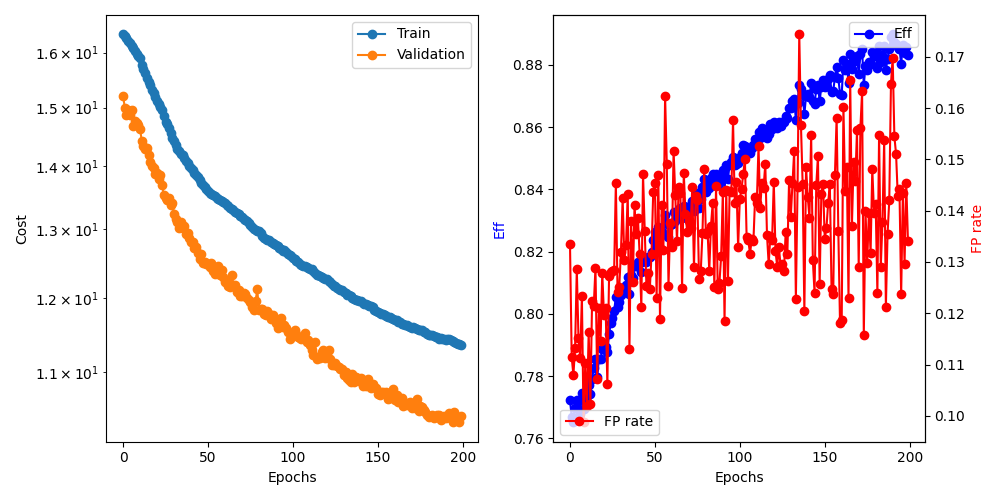

In [19]:
dual_train_plots(results.index,
                 results.cost, results.val, 
                 results['eff_val'].apply(lambda x: x.eff_rate),
                 results['eff_val'].apply(lambda x: x.fp_rate))
plt.tight_layout()
plt.savefig(str(output / f'{name}_stats_a.png'))

In [ ]:
##quit()